# Assignment 1 - Part of Speech Tagging

## Dependencies

In [1]:
# Uncomment this cell to install the required packages in colab

# !pip install lightning
# !pip install torchtext.data
# !pip install torchtext
# !pip install torch

In [2]:
# file management
import urllib
from pathlib import Path
import zipfile
import re
import os

# dataframe management
import pandas as pd

# data manipulation
import numpy as np

# for readability
from tqdm import tqdm

# pytorch
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pytorch lightning
from lightning import LightningModule
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# Glove and vocabulary
from torchtext.vocab import GloVe, build_vocab_from_iterator

d:\Users\edo\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## TASK 1: Corpus

* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

### Download the corpus

In [3]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)


def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")


def extract_dataset(download_path: Path, extract_path: Path):
    print("Extracting dataset... (it may take a while...)")
    with zipfile.ZipFile(download_path, 'r') as zip_file:
        zip_file.extractall(extract_path)

    print("Extraction completed!")

    Path.unlink(download_path)
    print("Deleted .zip dataset file")

In [4]:
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_name = "dependency_treebank"

print(f"Current work directory: {Path.cwd()}")

dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_zip_path = dataset_folder.joinpath("dependency_treebank.zip")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_zip_path.exists():
    download_dataset(dataset_zip_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_zip_path, dataset_folder)


Current work directory: c:\Users\merli\OneDrive\Desktop\Github repos\NLP\A1


### Encode the corpus into a pandas.DataFrame object and split it into train, validation and test sets

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199

In [5]:
dataframe_rows = []
id = 0

for i, file_path in enumerate(sorted(dataset_path.iterdir())):
    if file_path.is_file():  # split corpus documents in the tree categories: train, validation, tests
        if 1 <= i + 1 <= 100:
            split = 'train'
        elif 101 <= i + 1 <= 150:
            split = 'validation'
        else:
            split = 'test'

        with file_path.open(mode='r', encoding='utf-8') as text_file:  # read corpus lines
            lines = text_file.readlines()

        for line in lines:
            fields = line.strip().split('\t')
            if len(fields) == 1:
                id = id + 1
            if len(fields) >= 2:
                text = fields[0]   # store the first field as 'text'
                POS = fields[1]    # store the second field as 'POS'
                dataframe_row = {  # build DataFrame rows
                    "text": text,
                    "POS": POS,
                    "split": split,
                    "id": id
                }

                dataframe_rows.append(dataframe_row)  #append rows
# corpus DataFrame
corpus_df = pd.DataFrame(dataframe_rows)

#### Data inspection

In [6]:
corpus_df.head(10)

,text,POS,split,id
0,Pierre,NNP,train,0
1,Vinken,NNP,train,0
2,",",",",train,0
3,61,CD,train,0
4,years,NNS,train,0
5,old,JJ,train,0
6,",",",",train,0
7,will,MD,train,0
8,join,VB,train,0
9,the,DT,train,0


In [7]:
print("Dataframe structure:")
print(corpus_df)
print()

print(f"Total rows {len(corpus_df)}")
print()

Dataframe structure:
          text  POS  split    id
0       Pierre  NNP  train     0
1       Vinken  NNP  train     0
2            ,    ,  train     0
3           61   CD  train     0
4        years  NNS  train     0
...        ...  ...    ...   ...
94079  quarter   NN   test  3715
94080       of   IN   test  3715
94081     next   JJ   test  3715
94082     year   NN   test  3715
94083        .    .   test  3715

[94084 rows x 4 columns]

Total rows 94084



In [8]:
# Train, test, validation split
df_train = corpus_df[corpus_df['split'] == 'train'].drop(columns=['split'])
df_test = corpus_df[corpus_df['split'] == 'test'].drop(columns=['split'])
df_val = corpus_df[corpus_df['split'] == 'validation'].drop(columns=['split'])

## TASK 2: Text encoding

* Embed words using **GloVe embeddings**.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

In [9]:
def load_embedding_model(embedding_dimension: int = 300):
    emb_model = GloVe(name="6B", dim=embedding_dimension)
    return emb_model

In [10]:
# Puntuaction and symbols in the dataset
punctuation_and_symbol_pos = [".", ",", ":", '``', "''", "$", "#", "-LRB-", "-RRB-", "SYM", "LS"]  

### TASK 4.b: OOV tokens
Since GloVe is used as word embedding there could be some words in the training set that does not have a corresponding embedding. To avoid having words in the training set that are considered as OOV we add them to the vocabulary with the corresponding embedding. This one is computed by sampling from a normal distribution with mean and variance equal to the one of the vectors in GloVe

In [11]:
# Find training set OOV tokens
embedding_dim = 300
embedder = load_embedding_model(embedding_dim)

existing_vocab_tokens = set(embedder.itos)  # Tokens in the vocabulary, i.e. present in GloVe
train_text = set([word.lower() for word in df_train['text']])

train_oov_tokens = train_text - existing_vocab_tokens
print(f"OOV tokens in the training set: {len(train_oov_tokens)}")
print(f"Some OOV tokens: {list(train_oov_tokens)[:50]}")

OOV tokens in the training set: 359
Some OOV tokens: ['when-issued', 'dollar-yen', 'chilver', 'one-country', 'capital-gains', 'dead-eyed', 'sharedata', '449.04', 'morale-damaging', '382-37', 'sometimes-exhausting', 'hallwood', '4,393,237', 'norwick', 'prize-fighter', 'home-market', 'tarwhine', 'purepac', '497.34', 'twindam', 'higher-salaried', 'non-biodegradable', 'purhasing', 'machine-gun-toting', 'page-one', '95,142', '5\\/8', '70-a-share', 'sub-markets', 'sanderoff', 'mortgage-based', 'micronite', 'northy', 'preparatives', 'auto-safety', 'corton-charlemagne', 'cotran', 'delwin', 'market-share', 'asset-sale', 'coche-dury', '90-cent-an-hour', 'rubinfien', 'ariail', 'six-packs', 'subindustry', 'yen-denominated', '352.7', 'weisfield', 'macheski']


In [12]:
# Add training set OOV tokens to the GloVe embedder, sampling from a normal distribution centered in the mean of the GloVe embeddings and with the same standard deviation

means = torch.mean(embedder.vectors, dim=0)
stds = torch.std(embedder.vectors, dim=0)

for token in train_oov_tokens:
    embedder.itos.append(token)
    embedder.stoi[token] = len(embedder.itos) - 1
    embedder.vectors = torch.cat((embedder.vectors, torch.normal(means, stds).unsqueeze(dim=0)), dim=0)

# For the '[UNK]' token embedding, sample a vector from as done before for the OOV tokens
# Mean and std of the GloVe embeddings, for each feature
unk_vector = torch.normal(means, stds)

# The '[UNK]' token is not really added to the vocabulary (i.e. GloVe)
# instead, we redefine the 'unk_init' function of the embedder to return the embedding vector corresponding to '[UNK]'
embedder.unk_init = lambda x: unk_vector

print(f"New vocabulary size: {len(embedder.itos)}")

assert len(embedder.itos) == len(embedder.stoi) == embedder.vectors.shape[0]

New vocabulary size: 400359


### Embed words using GloVe embeddings

For the token to embedding mapping, we decided to use the following approach: the Dataset object takes care of calling the embedder every time it is queried to return a datapoint (\_\_getitem\_\_ method)

In [13]:
iterator = ([pos] for pos in corpus_df["POS"].unique())
pos_vocab = build_vocab_from_iterator(iterator)
pos_vocab.append_token("<PAD>")

pos_padding_value = pos_vocab["<PAD>"]
punctuation_and_symbol_pos_indices = [pos_vocab[token] for token in punctuation_and_symbol_pos]


class CorpusDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, embedder):
        min_id = dataframe['id'].min()
        dataframe['id'] = dataframe['id'] - min_id
        self.dataframe = dataframe.groupby("id")
        self.embedder = embedder

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sentence = self.dataframe.get_group(idx)
        text = sentence['text'].to_list()
        text = [token.lower() for token in text]

        POS = sentence['POS'].to_list()
        POS = torch.Tensor([pos_vocab[token] for token in POS])

        embedded_text = self.embedder.get_vecs_by_tokens(text)

        return embedded_text, POS


In [14]:
# Definition of the datasets
dataset_train = CorpusDataset(df_train, embedder)
dataset_test = CorpusDataset(df_test, embedder)
dataset_val = CorpusDataset(df_val, embedder)


# This collate function takes care of adding padding to the sequences
def pad_collate(batch):
    sequences, labels = zip(*batch)

    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    labels_padded = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=pos_padding_value)

    sequences_padded = sequences_padded.type(torch.float)
    labels_padded = labels_padded.type(torch.long)

    return [sequences_padded, labels_padded]

batch_size = 64

train_loader = DataLoader(dataset_train, batch_size=batch_size, collate_fn=pad_collate)
val_loader = DataLoader(dataset_val, batch_size=batch_size, collate_fn=pad_collate)
test_loader = DataLoader(dataset_test, batch_size=batch_size, collate_fn=pad_collate)

## TASK 4: Metrics

* Evaluate models using macro F1-score, computed over **all** tokens.

We defined our own macro F1-score metric in order to accumulate FP, TP, FN, TN iteratively

In [15]:
from torchmetrics import Metric
from torchmetrics import ConfusionMatrix


class F1ScoreCustom(Metric):
    def __init__(self, num_classes: int, pos_padding_value: int = pos_padding_value,
                 punctuation_and_symbol_pos_indices: list = punctuation_and_symbol_pos_indices):
        super().__init__()

        self.num_classes = num_classes
        self.mask = torch.ones([num_classes], dtype=torch.bool)
        self.mask[[pos_padding_value] + punctuation_and_symbol_pos_indices] = 0

        self.add_state("true_positive", default=torch.zeros([num_classes]), dist_reduce_fx="sum")
        self.add_state("false_negative", default=torch.zeros([num_classes]), dist_reduce_fx="sum")
        self.add_state("false_positive", default=torch.zeros([num_classes]), dist_reduce_fx="sum")

    def update(self, y_hat_class: torch.Tensor, y_class: torch.Tensor):
        confusion_matrix_metric = ConfusionMatrix(num_classes=self.num_classes, task="multiclass")
        confusion_matrix = confusion_matrix_metric(y_hat_class, y_class)

        # #  Example of multiclass confusion matrix:
        # #  Confusion matrix, TP, FN and FP for class 0 
        # #   TRUE LABEL
        # #   0               TP     FN     FN     FN     FN       
        # #   1               FP       
        # #   2               FP               
        # #   3               FP                       
        # #   4               FP                                
        # # PREDICTED LABEL   0       1      2      3      4 

        true_positive = torch.Tensor([confusion_matrix[i][i] for i in range(self.num_classes)])
        false_negative = torch.Tensor([sum(confusion_matrix[i, :]) - true_positive[i] for i in range(self.num_classes)])
        false_positive = torch.Tensor([sum(confusion_matrix[:, i]) - true_positive[i] for i in range(self.num_classes)])

        self.true_positive += true_positive
        self.false_negative += false_negative
        self.false_positive += false_positive

    def compute(self):
        precision = self.true_positive / (self.true_positive + self.false_positive)
        recall = self.true_positive / (self.true_positive + self.false_negative)

        f1 = 2 * (precision * recall) / (precision + recall)

        return f1[self.mask]



## TASK 3: Model definition

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

### Baseline model: Bidirectional LSTM + Dense layer

In [16]:
class BiLSTMModel(LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, target_padding_value=pos_padding_value):
        super(BiLSTMModel, self).__init__()

        self.save_hyperparameters()

        self.output_dim = output_dim
        self.target_padding_value = target_padding_value

        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            batch_first=True,
                            bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiplied by 2 due to the bidirectionality

        self._train_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)
        self._val_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)
        self._test_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out) 
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)  # (batch_size, seq_length, output_dim)

        # Change shape from (batch_size, sequence_len, classes) to be (batch_size, classes, sequence_len) to compute loss function
        y_hat = torch.movedim(y_hat, 1, 2)

        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)

        self.log_dict({'train_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True,
                      on_step=False, reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._train_f1_metric.update(y_hat_class, y)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.movedim(y_hat, 1, 2)

        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)
        self.log_dict({'val_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, logger=True,
                      reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._val_f1_metric.update(y_hat_class, y)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.movedim(y_hat, 1, 2)
        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)

        self.log_dict({'test_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, logger=True,
                      reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._test_f1_metric.update(y_hat_class, y)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def _compute_f1(self, f1_metric):
        mean_f1_score = f1_metric.compute()

        # Create a mask that is False for NaNs
        mask = torch.isnan(mean_f1_score)

        # Invert the mask: True for valid entries, False for NaNs
        valid_data = mean_f1_score[~mask]

        # Compute the mean of the non-NaN values
        mean_value = torch.mean(valid_data)

        return mean_value

    def on_train_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._train_f1_metric)
        self.log_dict({"train_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._train_f1_metric.reset()

    def on_validation_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._val_f1_metric)
        self.log_dict({"val_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._val_f1_metric.reset()

    def on_test_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._test_f1_metric)
        self.log_dict({"test_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._test_f1_metric.reset()


### Model 1: Bidirectional 2-layers LSTM + Dense layer

In [17]:
class Model1(LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, target_padding_value=pos_padding_value):
        super(Model1, self).__init__()

        self.save_hyperparameters()

        self.output_dim = output_dim
        self.target_padding_value = target_padding_value

        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiplied by 2 due to the bidirectionality

        self._train_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)
        self._val_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)
        self._test_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # Change shape from (batchsize, sequence_len, classes) to be (batchsize, classes, sequence_len) to compute loss function
        y_hat = torch.movedim(y_hat, 1, 2)
        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)

        self.log_dict({'train_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True,
                      on_step=False, reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._train_f1_metric.update(y_hat_class, y)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.movedim(y_hat, 1, 2)

        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)
        self.log_dict({'val_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, logger=True,
                      reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._val_f1_metric.update(y_hat_class, y)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.movedim(y_hat, 1, 2)
        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)

        self.log_dict({'test_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, logger=True,
                      reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._test_f1_metric.update(y_hat_class, y)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def _compute_f1(self, f1_metric):
        mean_f1_score = f1_metric.compute()

        # Create a mask that is False for NaNs
        mask = torch.isnan(mean_f1_score)

        # Invert the mask: True for valid entries, False for NaNs
        valid_data = mean_f1_score[~mask]

        # Compute the mean of the non-NaN values
        mean_value = torch.mean(valid_data)

        return mean_value

    def on_train_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._train_f1_metric)
        self.log_dict({"train_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._train_f1_metric.reset()

    def on_validation_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._val_f1_metric)
        self.log_dict({"val_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._val_f1_metric.reset()

    def on_test_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._test_f1_metric)
        self.log_dict({"test_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._test_f1_metric.reset()

### Model 2: Bidirectional LSTM + 2 Dense layers

In [18]:
class Model2(LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, fc_size,
                 target_padding_value=pos_padding_value):
        super(Model2, self).__init__()

        self.save_hyperparameters()
        
        self.output_dim = output_dim
        self.target_padding_value = target_padding_value

        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)
        self.fc_1 = nn.Linear(hidden_dim * 2, fc_size)  # Multiplied by 2 due to bidirectionality
        self.relu = nn.ReLU()
        self.fc_2 = nn.Linear(fc_size, output_dim)  

        self._train_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)
        self._val_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)
        self._test_f1_metric = F1ScoreCustom(num_classes=output_dim, pos_padding_value=self.target_padding_value)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc_1(lstm_out)
        out = self.relu(out)
        out = self.fc_2(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # Change shape from (batch_size, sequence_len, classes) to be (batch_size, classes, sequence_len) to compute loss function
        y_hat = torch.movedim(y_hat, 1, 2)
        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)

        self.log_dict({'train_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True,
                      on_step=False, reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._train_f1_metric.update(y_hat_class, y)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.movedim(y_hat, 1, 2)

        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)
        self.log_dict({'val_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, logger=True,
                      reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._val_f1_metric.update(y_hat_class, y)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.movedim(y_hat, 1, 2)
        loss = nn.functional.cross_entropy(y_hat, y, ignore_index=self.target_padding_value)

        self.log_dict({'test_loss': loss, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True, logger=True,
                      reduce_fx="mean")

        y_hat_class = torch.argmax(y_hat, dim=1)
        self._test_f1_metric.update(y_hat_class, y)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def _compute_f1(self, f1_metric):
        mean_f1_score = f1_metric.compute()

        # Create a mask that is False for NaNs
        mask = torch.isnan(mean_f1_score)

        # Invert the mask: True for valid entries, False for NaNs
        valid_data = mean_f1_score[~mask]

        # Compute the mean of the non-NaN values
        mean_value = torch.mean(valid_data)

        return mean_value

    def on_train_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._train_f1_metric)
        self.log_dict({"train_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._train_f1_metric.reset()

    def on_validation_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._val_f1_metric)
        self.log_dict({"val_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._val_f1_metric.reset()

    def on_test_epoch_end(self) -> None:
        mean_f1_score = self._compute_f1(self._test_f1_metric)
        self.log_dict({"test_f1": mean_f1_score, 'step': float(self.current_epoch)}, on_epoch=True, prog_bar=True,
                      logger=True)
        self._test_f1_metric.reset()

## TASK 5: Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

In [19]:
# Fix all possible sources of randomness
torch.use_deterministic_algorithms(True)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Training and evaluation
Training all models on training set and evalutating on validation set at every epoch s.t. to keep the best model for each model/seed pair. Both cross entropy loss and F1-Score are computed at each evaluation.

In [20]:
logs_path = Path.cwd() / "logs" / "lightning_logs"
train = False

seeds = [6, 90, 157]

epochs = 100
output_dim = len(df_train["POS"].unique()) + 1  # +1 for padding
hidden_dim = 128
input_dim = embedding_dim

model_classes = [BiLSTMModel, Model1, Model2]
model_names = ["baseline", "model1", "model2"]
hyperparameters = [
    {'input_dim': input_dim, 'hidden_dim': hidden_dim, 'output_dim': output_dim},
    {'input_dim': input_dim, 'hidden_dim': hidden_dim, 'output_dim': output_dim},
    {'input_dim': input_dim, 'hidden_dim': hidden_dim, 'output_dim': output_dim, 'fc_size': 256}
]

if train:
    for model_class, model_name, hyperparameter in zip(model_classes, model_names, hyperparameters):
        for seed in seeds:
            print(f"Training model {model_name} with seed {seed}...")
            seed_everything(seed, workers=True)

            model = model_class(**hyperparameter)

            logger = TensorBoardLogger(logs_path, name=f"{model_name}_seed{seed}_emb{embedding_dim}")
            checkpoint_callback = ModelCheckpoint(
                monitor='val_loss',
                dirpath=None,
                filename=f'{model_name}-seed={seed}' + '-{epoch:02d}-{val_loss:.2f}-{val_f1:.2f}',
                save_top_k=1,
            )
            
            early_stop_callback = EarlyStopping(
                monitor='val_loss',
                patience=6,
                verbose=True,
                mode='min'
            )

            trainer = Trainer(
                max_epochs=epochs,
                logger=logger,
                log_every_n_steps=1,
                callbacks=[checkpoint_callback, early_stop_callback],
                deterministic=True
            )

            trainer.fit(model, train_loader, val_loader)
else:
    print("Skipping training...")

Seed set to 6


Training model baseline with seed 6...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\merli\OneDrive\Desktop\Github repos\NLP\A1\logs\lightning_logs\baseline_seed6_emb300

  | Name             | Type          | Params
---------------------------------------------------
0 | lstm             | LSTM          | 440 K 
1 | fc               | Linear        | 11.8 K
2 | _train_f1_metric | F1ScoreCustom | 0     
3 | _val_f1_metric   | F1ScoreCustom | 0     
4 | _test_f1_metric  | F1ScoreCustom | 0     
---------------------------------------------------
452 K     Trainable params
0         Non-trainable params
452 K     Total params
1.809     Total estimated model params size (MB)


Sanity Checking:   0%|          | 0/2 [00:00<?, ?it/s]

d:\Users\edo\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


d:\Users\edo\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 30/30 [00:26<00:00,  1.12it/s, v_num=0, val_loss=2.380, step=0.000, val_f1=0.346, train_loss=3.020]

Metric val_loss improved. New best score: 2.379


Epoch 1: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, v_num=0, val_loss=1.450, step=1.000, val_f1=0.533, train_loss=1.880, train_f1=0.142]

Metric val_loss improved by 0.932 >= min_delta = 0.0. New best score: 1.447


Epoch 2: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, v_num=0, val_loss=1.020, step=2.000, val_f1=0.656, train_loss=1.180, train_f1=0.364]

Metric val_loss improved by 0.428 >= min_delta = 0.0. New best score: 1.019


Epoch 3: 100%|██████████| 30/30 [00:28<00:00,  1.07it/s, v_num=0, val_loss=0.806, step=3.000, val_f1=0.695, train_loss=0.861, train_f1=0.563]

Metric val_loss improved by 0.213 >= min_delta = 0.0. New best score: 0.806


Epoch 4: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s, v_num=0, val_loss=0.679, step=4.000, val_f1=0.717, train_loss=0.689, train_f1=0.653]

Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 0.679


Epoch 5: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s, v_num=0, val_loss=0.595, step=5.000, val_f1=0.756, train_loss=0.579, train_f1=0.687]

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 0.595


Epoch 6: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s, v_num=0, val_loss=0.536, step=6.000, val_f1=0.726, train_loss=0.502, train_f1=0.747]

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 0.536


Epoch 7: 100%|██████████| 30/30 [00:23<00:00,  1.30it/s, v_num=0, val_loss=0.493, step=7.000, val_f1=0.743, train_loss=0.444, train_f1=0.719]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.493


Epoch 8: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s, v_num=0, val_loss=0.461, step=8.000, val_f1=0.763, train_loss=0.398, train_f1=0.743]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.461


Epoch 9: 100%|██████████| 30/30 [00:25<00:00,  1.15it/s, v_num=0, val_loss=0.437, step=9.000, val_f1=0.782, train_loss=0.361, train_f1=0.751]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.437


Epoch 10: 100%|██████████| 30/30 [00:23<00:00,  1.30it/s, v_num=0, val_loss=0.417, step=10.00, val_f1=0.792, train_loss=0.329, train_f1=0.775]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.417


Epoch 11: 100%|██████████| 30/30 [00:24<00:00,  1.25it/s, v_num=0, val_loss=0.401, step=11.00, val_f1=0.798, train_loss=0.301, train_f1=0.792]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.401


Epoch 12: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s, v_num=0, val_loss=0.388, step=12.00, val_f1=0.793, train_loss=0.276, train_f1=0.812]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.388


Epoch 13: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s, v_num=0, val_loss=0.377, step=13.00, val_f1=0.798, train_loss=0.253, train_f1=0.800]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.377


Epoch 14: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s, v_num=0, val_loss=0.367, step=14.00, val_f1=0.781, train_loss=0.232, train_f1=0.824]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.367


Epoch 15: 100%|██████████| 30/30 [00:23<00:00,  1.29it/s, v_num=0, val_loss=0.360, step=15.00, val_f1=0.784, train_loss=0.213, train_f1=0.836]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.360


Epoch 16: 100%|██████████| 30/30 [00:23<00:00,  1.30it/s, v_num=0, val_loss=0.354, step=16.00, val_f1=0.786, train_loss=0.196, train_f1=0.843]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.354


Epoch 17: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s, v_num=0, val_loss=0.349, step=17.00, val_f1=0.788, train_loss=0.180, train_f1=0.832]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.349


Epoch 18: 100%|██████████| 30/30 [23:57<00:00,  0.02it/s, v_num=0, val_loss=0.347, step=18.00, val_f1=0.781, train_loss=0.165, train_f1=0.856]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.347


Epoch 20: 100%|██████████| 30/30 [00:30<00:00,  0.99it/s, v_num=0, val_loss=0.340, step=20.00, val_f1=0.796, train_loss=0.140, train_f1=0.874]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.340


Epoch 22: 100%|██████████| 30/30 [00:29<00:00,  1.00it/s, v_num=0, val_loss=0.332, step=22.00, val_f1=0.797, train_loss=0.126, train_f1=0.887]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.332


Epoch 23: 100%|██████████| 30/30 [00:33<00:00,  0.91it/s, v_num=0, val_loss=0.331, step=23.00, val_f1=0.803, train_loss=0.113, train_f1=0.890]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.331


Epoch 29: 100%|██████████| 30/30 [00:36<00:00,  0.82it/s, v_num=0, val_loss=0.322, step=29.00, val_f1=0.785, train_loss=0.0706, train_f1=0.886]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.322


Epoch 30: 100%|██████████| 30/30 [00:33<00:00,  0.89it/s, v_num=0, val_loss=0.321, step=30.00, val_f1=0.789, train_loss=0.0643, train_f1=0.905]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.321


Epoch 31: 100%|██████████| 30/30 [00:32<00:00,  0.93it/s, v_num=0, val_loss=0.321, step=31.00, val_f1=0.787, train_loss=0.0628, train_f1=0.902]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.321


Epoch 37: 100%|██████████| 30/30 [00:32<00:00,  0.92it/s, v_num=0, val_loss=0.321, step=37.00, val_f1=0.785, train_loss=0.0571, train_f1=0.900]

Monitored metric val_loss did not improve in the last 6 records. Best score: 0.321. Signaling Trainer to stop.


Epoch 37: 100%|██████████| 30/30 [00:32<00:00,  0.92it/s, v_num=0, val_loss=0.321, step=37.00, val_f1=0.785, train_loss=0.0571, train_f1=0.900]

Seed set to 90
GPU available: False, used: False



Training model baseline with seed 90...


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\merli\OneDrive\Desktop\Github repos\NLP\A1\logs\lightning_logs\baseline_seed90_emb300

  | Name             | Type          | Params
---------------------------------------------------
0 | lstm             | LSTM          | 440 K 
1 | fc               | Linear        | 11.8 K
2 | _train_f1_metric | F1ScoreCustom | 0     
3 | _val_f1_metric   | F1ScoreCustom | 0     
4 | _test_f1_metric  | F1ScoreCustom | 0     
---------------------------------------------------
452 K     Trainable params
0         Non-trainable params
452 K     Total params
1.809     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 30/30 [00:29<00:00,  1.01it/s, v_num=0, val_loss=2.400, step=0.000, val_f1=0.330, train_loss=3.030]

Metric val_loss improved. New best score: 2.395


Epoch 1: 100%|██████████| 30/30 [00:29<00:00,  1.00it/s, v_num=0, val_loss=1.440, step=1.000, val_f1=0.564, train_loss=1.890, train_f1=0.103]

Metric val_loss improved by 0.951 >= min_delta = 0.0. New best score: 1.444


Epoch 2: 100%|██████████| 30/30 [00:32<00:00,  0.93it/s, v_num=0, val_loss=1.010, step=2.000, val_f1=0.652, train_loss=1.170, train_f1=0.396]

Metric val_loss improved by 0.437 >= min_delta = 0.0. New best score: 1.007


Epoch 3: 100%|██████████| 30/30 [00:29<00:00,  1.01it/s, v_num=0, val_loss=0.798, step=3.000, val_f1=0.710, train_loss=0.852, train_f1=0.568]

Metric val_loss improved by 0.209 >= min_delta = 0.0. New best score: 0.798


Epoch 4: 100%|██████████| 30/30 [00:29<00:00,  1.03it/s, v_num=0, val_loss=0.674, step=4.000, val_f1=0.722, train_loss=0.683, train_f1=0.674]

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 0.674


Epoch 5: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s, v_num=0, val_loss=0.592, step=5.000, val_f1=0.757, train_loss=0.575, train_f1=0.682]

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 0.592


Epoch 6: 100%|██████████| 30/30 [00:36<00:00,  0.83it/s, v_num=0, val_loss=0.534, step=6.000, val_f1=0.715, train_loss=0.498, train_f1=0.752]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.534


Epoch 7: 100%|██████████| 30/30 [00:33<00:00,  0.90it/s, v_num=0, val_loss=0.493, step=7.000, val_f1=0.739, train_loss=0.440, train_f1=0.712]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.493


Epoch 8: 100%|██████████| 30/30 [00:33<00:00,  0.90it/s, v_num=0, val_loss=0.462, step=8.000, val_f1=0.765, train_loss=0.395, train_f1=0.740]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.462


Epoch 9: 100%|██████████| 30/30 [00:33<00:00,  0.90it/s, v_num=0, val_loss=0.437, step=9.000, val_f1=0.784, train_loss=0.357, train_f1=0.782]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.437


Epoch 10: 100%|██████████| 30/30 [00:32<00:00,  0.92it/s, v_num=0, val_loss=0.417, step=10.00, val_f1=0.794, train_loss=0.325, train_f1=0.779]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.417


Epoch 11: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s, v_num=0, val_loss=0.401, step=11.00, val_f1=0.781, train_loss=0.297, train_f1=0.774]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.401


Epoch 12: 100%|██████████| 30/30 [00:29<00:00,  1.01it/s, v_num=0, val_loss=0.388, step=12.00, val_f1=0.789, train_loss=0.272, train_f1=0.785]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.388


Epoch 13: 100%|██████████| 30/30 [00:33<00:00,  0.89it/s, v_num=0, val_loss=0.377, step=13.00, val_f1=0.798, train_loss=0.250, train_f1=0.801]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.377


Epoch 14: 100%|██████████| 30/30 [00:32<00:00,  0.93it/s, v_num=0, val_loss=0.368, step=14.00, val_f1=0.781, train_loss=0.230, train_f1=0.819]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.368


Epoch 15: 100%|██████████| 30/30 [00:33<00:00,  0.91it/s, v_num=0, val_loss=0.360, step=15.00, val_f1=0.786, train_loss=0.211, train_f1=0.828]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.360


Epoch 16: 100%|██████████| 30/30 [00:31<00:00,  0.96it/s, v_num=0, val_loss=0.354, step=16.00, val_f1=0.786, train_loss=0.193, train_f1=0.837]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.354


Epoch 17: 100%|██████████| 30/30 [00:30<00:00,  0.98it/s, v_num=0, val_loss=0.349, step=17.00, val_f1=0.786, train_loss=0.177, train_f1=0.850]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.349


Epoch 18: 100%|██████████| 30/30 [00:30<00:00,  0.98it/s, v_num=0, val_loss=0.344, step=18.00, val_f1=0.786, train_loss=0.162, train_f1=0.855]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.344


Epoch 19: 100%|██████████| 30/30 [00:30<00:00,  0.99it/s, v_num=0, val_loss=0.340, step=19.00, val_f1=0.788, train_loss=0.148, train_f1=0.860]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.340


Epoch 20: 100%|██████████| 30/30 [00:31<00:00,  0.96it/s, v_num=0, val_loss=0.337, step=20.00, val_f1=0.792, train_loss=0.135, train_f1=0.845]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.337


Epoch 23: 100%|██████████| 30/30 [00:29<00:00,  1.00it/s, v_num=0, val_loss=0.334, step=23.00, val_f1=0.799, train_loss=0.118, train_f1=0.873]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.334


Epoch 29: 100%|██████████| 30/30 [00:29<00:00,  1.03it/s, v_num=0, val_loss=0.326, step=29.00, val_f1=0.779, train_loss=0.0616, train_f1=0.883]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.326


Epoch 30: 100%|██████████| 30/30 [00:30<00:00,  0.98it/s, v_num=0, val_loss=0.326, step=30.00, val_f1=0.777, train_loss=0.0592, train_f1=0.883]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.326


Epoch 36: 100%|██████████| 30/30 [00:30<00:00,  0.98it/s, v_num=0, val_loss=0.327, step=36.00, val_f1=0.785, train_loss=0.0545, train_f1=0.893]

Monitored metric val_loss did not improve in the last 6 records. Best score: 0.326. Signaling Trainer to stop.


Epoch 36: 100%|██████████| 30/30 [00:30<00:00,  0.98it/s, v_num=0, val_loss=0.327, step=36.00, val_f1=0.785, train_loss=0.0545, train_f1=0.893]

Seed set to 157



Training model baseline with seed 157...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\merli\OneDrive\Desktop\Github repos\NLP\A1\logs\lightning_logs\baseline_seed157_emb300

  | Name             | Type          | Params
---------------------------------------------------
0 | lstm             | LSTM          | 440 K 
1 | fc               | Linear        | 11.8 K
2 | _train_f1_metric | F1ScoreCustom | 0     
3 | _val_f1_metric   | F1ScoreCustom | 0     
4 | _test_f1_metric  | F1ScoreCustom | 0     
---------------------------------------------------
452 K     Trainable params
0         Non-trainable params
452 K     Total params
1.809     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 30/30 [00:31<00:00,  0.96it/s, v_num=0, val_loss=2.440, step=0.000, val_f1=0.355, train_loss=3.050]

Metric val_loss improved. New best score: 2.439


Epoch 1: 100%|██████████| 30/30 [00:29<00:00,  1.01it/s, v_num=0, val_loss=1.480, step=1.000, val_f1=0.525, train_loss=1.950, train_f1=0.123]

Metric val_loss improved by 0.956 >= min_delta = 0.0. New best score: 1.484


Epoch 2: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s, v_num=0, val_loss=1.020, step=2.000, val_f1=0.660, train_loss=1.190, train_f1=0.383]

Metric val_loss improved by 0.467 >= min_delta = 0.0. New best score: 1.017


Epoch 3: 100%|██████████| 30/30 [00:29<00:00,  1.01it/s, v_num=0, val_loss=0.801, step=3.000, val_f1=0.647, train_loss=0.856, train_f1=0.563]

Metric val_loss improved by 0.216 >= min_delta = 0.0. New best score: 0.801


Epoch 4: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s, v_num=0, val_loss=0.676, step=4.000, val_f1=0.719, train_loss=0.684, train_f1=0.643]

Metric val_loss improved by 0.125 >= min_delta = 0.0. New best score: 0.676


Epoch 5: 100%|██████████| 30/30 [00:31<00:00,  0.96it/s, v_num=0, val_loss=0.592, step=5.000, val_f1=0.725, train_loss=0.576, train_f1=0.682]

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 0.592


Epoch 6: 100%|██████████| 30/30 [00:30<00:00,  1.00it/s, v_num=0, val_loss=0.534, step=6.000, val_f1=0.700, train_loss=0.500, train_f1=0.721]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 0.534


Epoch 7: 100%|██████████| 30/30 [00:29<00:00,  1.01it/s, v_num=0, val_loss=0.493, step=7.000, val_f1=0.741, train_loss=0.442, train_f1=0.721]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.493


Epoch 8: 100%|██████████| 30/30 [00:30<00:00,  0.99it/s, v_num=0, val_loss=0.462, step=8.000, val_f1=0.771, train_loss=0.397, train_f1=0.748]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.462


Epoch 9: 100%|██████████| 30/30 [00:29<00:00,  1.01it/s, v_num=0, val_loss=0.438, step=9.000, val_f1=0.789, train_loss=0.360, train_f1=0.787]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.438


Epoch 10: 100%|██████████| 30/30 [00:30<00:00,  0.97it/s, v_num=0, val_loss=0.418, step=10.00, val_f1=0.808, train_loss=0.328, train_f1=0.758]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.418


Epoch 11: 100%|██████████| 30/30 [00:30<00:00,  0.97it/s, v_num=0, val_loss=0.402, step=11.00, val_f1=0.796, train_loss=0.300, train_f1=0.775]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.402


Epoch 12: 100%|██████████| 30/30 [00:30<00:00,  1.00it/s, v_num=0, val_loss=0.389, step=12.00, val_f1=0.816, train_loss=0.275, train_f1=0.796]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.389


Epoch 13: 100%|██████████| 30/30 [00:29<00:00,  1.01it/s, v_num=0, val_loss=0.378, step=13.00, val_f1=0.827, train_loss=0.253, train_f1=0.816]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.378


Epoch 14: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s, v_num=0, val_loss=0.369, step=14.00, val_f1=0.833, train_loss=0.233, train_f1=0.833]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.369


Epoch 15: 100%|██████████| 30/30 [00:30<00:00,  1.00it/s, v_num=0, val_loss=0.361, step=15.00, val_f1=0.834, train_loss=0.214, train_f1=0.845]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.361


Epoch 16: 100%|██████████| 30/30 [00:31<00:00,  0.96it/s, v_num=0, val_loss=0.356, step=16.00, val_f1=0.835, train_loss=0.196, train_f1=0.855]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.356


Epoch 17: 100%|██████████| 30/30 [00:31<00:00,  0.95it/s, v_num=0, val_loss=0.352, step=17.00, val_f1=0.810, train_loss=0.180, train_f1=0.864]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.352


Epoch 18: 100%|██████████| 30/30 [00:34<00:00,  0.87it/s, v_num=0, val_loss=0.349, step=18.00, val_f1=0.809, train_loss=0.165, train_f1=0.872]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.349


Epoch 21: 100%|██████████| 30/30 [00:30<00:00,  0.99it/s, v_num=0, val_loss=0.338, step=21.00, val_f1=0.812, train_loss=0.131, train_f1=0.894]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.338


Epoch 22: 100%|██████████| 30/30 [00:31<00:00,  0.94it/s, v_num=0, val_loss=0.337, step=22.00, val_f1=0.820, train_loss=0.124, train_f1=0.896]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.337


Epoch 23: 100%|██████████| 30/30 [00:31<00:00,  0.96it/s, v_num=0, val_loss=0.335, step=23.00, val_f1=0.822, train_loss=0.115, train_f1=0.900]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.335


Epoch 29: 100%|██████████| 30/30 [00:33<00:00,  0.91it/s, v_num=0, val_loss=0.327, step=29.00, val_f1=0.824, train_loss=0.070, train_f1=0.901] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.327


Epoch 30: 100%|██████████| 30/30 [00:31<00:00,  0.96it/s, v_num=0, val_loss=0.326, step=30.00, val_f1=0.824, train_loss=0.0639, train_f1=0.911]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.326


Epoch 31: 100%|██████████| 30/30 [00:30<00:00,  0.98it/s, v_num=0, val_loss=0.326, step=31.00, val_f1=0.824, train_loss=0.0623, train_f1=0.916]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.326


Epoch 37: 100%|██████████| 30/30 [00:30<00:00,  0.99it/s, v_num=0, val_loss=0.327, step=37.00, val_f1=0.819, train_loss=0.057, train_f1=0.914] 

Monitored metric val_loss did not improve in the last 6 records. Best score: 0.326. Signaling Trainer to stop.


Epoch 37: 100%|██████████| 30/30 [00:30<00:00,  0.99it/s, v_num=0, val_loss=0.327, step=37.00, val_f1=0.819, train_loss=0.057, train_f1=0.914]

Seed set to 6
GPU available: False, used: False



Training model model1 with seed 6...


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\merli\OneDrive\Desktop\Github repos\NLP\A1\logs\lightning_logs\model1_seed6_emb300

  | Name             | Type          | Params
---------------------------------------------------
0 | lstm             | LSTM          | 835 K 
1 | fc               | Linear        | 11.8 K
2 | _train_f1_metric | F1ScoreCustom | 0     
3 | _val_f1_metric   | F1ScoreCustom | 0     
4 | _test_f1_metric  | F1ScoreCustom | 0     
---------------------------------------------------
847 K     Trainable params
0         Non-trainable params
847 K     Total params
3.390     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 30/30 [00:41<00:00,  0.72it/s, v_num=0, val_loss=2.660, step=0.000, val_f1=0.334, train_loss=3.120]

Metric val_loss improved. New best score: 2.665


Epoch 1: 100%|██████████| 30/30 [00:41<00:00,  0.72it/s, v_num=0, val_loss=1.710, step=1.000, val_f1=0.391, train_loss=2.200, train_f1=0.0913]

Metric val_loss improved by 0.959 >= min_delta = 0.0. New best score: 1.706


Epoch 2: 100%|██████████| 30/30 [00:42<00:00,  0.70it/s, v_num=0, val_loss=1.160, step=2.000, val_f1=0.552, train_loss=1.380, train_f1=0.291] 

Metric val_loss improved by 0.550 >= min_delta = 0.0. New best score: 1.156


Epoch 3: 100%|██████████| 30/30 [00:43<00:00,  0.69it/s, v_num=0, val_loss=0.859, step=3.000, val_f1=0.692, train_loss=0.960, train_f1=0.461]

Metric val_loss improved by 0.296 >= min_delta = 0.0. New best score: 0.859


Epoch 4: 100%|██████████| 30/30 [00:42<00:00,  0.70it/s, v_num=0, val_loss=0.696, step=4.000, val_f1=0.745, train_loss=0.725, train_f1=0.639]

Metric val_loss improved by 0.163 >= min_delta = 0.0. New best score: 0.696


Epoch 5: 100%|██████████| 30/30 [00:41<00:00,  0.73it/s, v_num=0, val_loss=0.592, step=5.000, val_f1=0.728, train_loss=0.584, train_f1=0.684]

Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 0.592


Epoch 6: 100%|██████████| 30/30 [00:42<00:00,  0.71it/s, v_num=0, val_loss=0.518, step=6.000, val_f1=0.779, train_loss=0.487, train_f1=0.704]

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 0.518


Epoch 7: 100%|██████████| 30/30 [00:42<00:00,  0.71it/s, v_num=0, val_loss=0.464, step=7.000, val_f1=0.783, train_loss=0.413, train_f1=0.717]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.464


Epoch 8: 100%|██████████| 30/30 [00:42<00:00,  0.71it/s, v_num=0, val_loss=0.424, step=8.000, val_f1=0.787, train_loss=0.356, train_f1=0.773]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.424


Epoch 9: 100%|██████████| 30/30 [00:41<00:00,  0.73it/s, v_num=0, val_loss=0.394, step=9.000, val_f1=0.786, train_loss=0.309, train_f1=0.793]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.394


Epoch 10: 100%|██████████| 30/30 [00:44<00:00,  0.67it/s, v_num=0, val_loss=0.371, step=10.00, val_f1=0.787, train_loss=0.271, train_f1=0.803]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.371


Epoch 11: 100%|██████████| 30/30 [00:42<00:00,  0.70it/s, v_num=0, val_loss=0.356, step=11.00, val_f1=0.809, train_loss=0.238, train_f1=0.811]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.356


Epoch 13: 100%|██████████| 30/30 [00:40<00:00,  0.73it/s, v_num=0, val_loss=0.334, step=13.00, val_f1=0.809, train_loss=0.197, train_f1=0.817]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.334


Epoch 14: 100%|██████████| 30/30 [00:44<00:00,  0.67it/s, v_num=0, val_loss=0.319, step=14.00, val_f1=0.792, train_loss=0.169, train_f1=0.835]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.319


Epoch 15: 100%|██████████| 30/30 [00:42<00:00,  0.71it/s, v_num=0, val_loss=0.313, step=15.00, val_f1=0.803, train_loss=0.146, train_f1=0.852]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.313


Epoch 16: 100%|██████████| 30/30 [00:42<00:00,  0.71it/s, v_num=0, val_loss=0.304, step=16.00, val_f1=0.814, train_loss=0.126, train_f1=0.863]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.304


Epoch 22: 100%|██████████| 30/30 [00:42<00:00,  0.71it/s, v_num=0, val_loss=0.288, step=22.00, val_f1=0.836, train_loss=0.0593, train_f1=0.899]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.288


Epoch 23: 100%|██████████| 30/30 [00:44<00:00,  0.68it/s, v_num=0, val_loss=0.287, step=23.00, val_f1=0.830, train_loss=0.0536, train_f1=0.911]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.287


Epoch 24: 100%|██████████| 30/30 [00:41<00:00,  0.73it/s, v_num=0, val_loss=0.287, step=24.00, val_f1=0.832, train_loss=0.0516, train_f1=0.911]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.287


Epoch 30: 100%|██████████| 30/30 [00:27<00:00,  1.11it/s, v_num=0, val_loss=0.287, step=30.00, val_f1=0.833, train_loss=0.0453, train_f1=0.896]

Monitored metric val_loss did not improve in the last 6 records. Best score: 0.287. Signaling Trainer to stop.


Epoch 30: 100%|██████████| 30/30 [00:27<00:00,  1.11it/s, v_num=0, val_loss=0.287, step=30.00, val_f1=0.833, train_loss=0.0453, train_f1=0.896]

Seed set to 90
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\merli\OneDrive\Desktop\Github repos\NLP\A1\logs\lightning_logs\model1_seed90_emb300

  | Name             | Type          | Params
---------------------------------------------------
0 | lstm             | LSTM          | 835 K 
1 | fc               | Linear        | 11.8 K
2 | _train_f1_metric | F1ScoreCustom | 0     
3 | _val_f1_metric   | F1ScoreCustom | 0     
4 | _test_f1_metric  | F1ScoreCustom | 0     
---------------------------------------------------
847 K     Trainable params
0         Non-trainable params
847 K     Total params
3.390     Total estimated model params size (MB)



Training model model1 with seed 90...
Epoch 0: 100%|██████████| 30/30 [00:20<00:00,  1.44it/s, v_num=0, val_loss=2.740, step=0.000, val_f1=0.325, train_loss=3.130]

Metric val_loss improved. New best score: 2.736


Epoch 1: 100%|██████████| 30/30 [00:21<00:00,  1.40it/s, v_num=0, val_loss=1.730, step=1.000, val_f1=0.396, train_loss=2.250, train_f1=0.0851]

Metric val_loss improved by 1.007 >= min_delta = 0.0. New best score: 1.730


Epoch 2: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s, v_num=0, val_loss=1.140, step=2.000, val_f1=0.535, train_loss=1.380, train_f1=0.238] 

Metric val_loss improved by 0.587 >= min_delta = 0.0. New best score: 1.143


Epoch 3: 100%|██████████| 30/30 [00:21<00:00,  1.36it/s, v_num=0, val_loss=0.853, step=3.000, val_f1=0.697, train_loss=0.951, train_f1=0.464]

Metric val_loss improved by 0.290 >= min_delta = 0.0. New best score: 0.853


Epoch 4: 100%|██████████| 30/30 [00:21<00:00,  1.39it/s, v_num=0, val_loss=0.692, step=4.000, val_f1=0.710, train_loss=0.722, train_f1=0.637]

Metric val_loss improved by 0.161 >= min_delta = 0.0. New best score: 0.692


Epoch 5: 100%|██████████| 30/30 [00:21<00:00,  1.40it/s, v_num=0, val_loss=0.590, step=5.000, val_f1=0.721, train_loss=0.582, train_f1=0.720]

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 0.590


Epoch 6: 100%|██████████| 30/30 [00:21<00:00,  1.37it/s, v_num=0, val_loss=0.520, step=6.000, val_f1=0.729, train_loss=0.486, train_f1=0.701]

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.520


Epoch 7: 100%|██████████| 30/30 [00:22<00:00,  1.34it/s, v_num=0, val_loss=0.468, step=7.000, val_f1=0.743, train_loss=0.413, train_f1=0.724]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.468


Epoch 8: 100%|██████████| 30/30 [00:21<00:00,  1.38it/s, v_num=0, val_loss=0.429, step=8.000, val_f1=0.773, train_loss=0.356, train_f1=0.777]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.429


Epoch 9: 100%|██████████| 30/30 [00:21<00:00,  1.38it/s, v_num=0, val_loss=0.398, step=9.000, val_f1=0.769, train_loss=0.309, train_f1=0.755]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.398


Epoch 10: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s, v_num=0, val_loss=0.374, step=10.00, val_f1=0.769, train_loss=0.269, train_f1=0.797]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.374


Epoch 11: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s, v_num=0, val_loss=0.356, step=11.00, val_f1=0.797, train_loss=0.236, train_f1=0.824]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.356


Epoch 12: 100%|██████████| 30/30 [00:20<00:00,  1.46it/s, v_num=0, val_loss=0.343, step=12.00, val_f1=0.808, train_loss=0.206, train_f1=0.797]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.343


Epoch 13: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s, v_num=0, val_loss=0.343, step=13.00, val_f1=0.811, train_loss=0.181, train_f1=0.815]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.343


Epoch 15: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s, v_num=0, val_loss=0.332, step=15.00, val_f1=0.798, train_loss=0.160, train_f1=0.850]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.332


Epoch 16: 100%|██████████| 30/30 [00:23<00:00,  1.29it/s, v_num=0, val_loss=0.316, step=16.00, val_f1=0.802, train_loss=0.142, train_f1=0.864]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.316


Epoch 20: 100%|██████████| 30/30 [00:21<00:00,  1.37it/s, v_num=0, val_loss=0.316, step=20.00, val_f1=0.805, train_loss=0.0831, train_f1=0.880]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.316


Epoch 26: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s, v_num=0, val_loss=0.305, step=26.00, val_f1=0.813, train_loss=0.0421, train_f1=0.924]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.305


Epoch 27: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s, v_num=0, val_loss=0.300, step=27.00, val_f1=0.827, train_loss=0.0319, train_f1=0.935]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.300


Epoch 28: 100%|██████████| 30/30 [00:24<00:00,  1.25it/s, v_num=0, val_loss=0.300, step=28.00, val_f1=0.827, train_loss=0.0304, train_f1=0.936]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.300


Epoch 34: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, v_num=0, val_loss=0.301, step=34.00, val_f1=0.821, train_loss=0.0269, train_f1=0.942]

Monitored metric val_loss did not improve in the last 6 records. Best score: 0.300. Signaling Trainer to stop.


Epoch 34: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, v_num=0, val_loss=0.301, step=34.00, val_f1=0.821, train_loss=0.0269, train_f1=0.942]

Seed set to 157



Training model model1 with seed 157...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\merli\OneDrive\Desktop\Github repos\NLP\A1\logs\lightning_logs\model1_seed157_emb300

  | Name             | Type          | Params
---------------------------------------------------
0 | lstm             | LSTM          | 835 K 
1 | fc               | Linear        | 11.8 K
2 | _train_f1_metric | F1ScoreCustom | 0     
3 | _val_f1_metric   | F1ScoreCustom | 0     
4 | _test_f1_metric  | F1ScoreCustom | 0     
---------------------------------------------------
847 K     Trainable params
0         Non-trainable params
847 K     Total params
3.390     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 30/30 [00:23<00:00,  1.26it/s, v_num=0, val_loss=2.690, step=0.000, val_f1=0.263, train_loss=3.130]

Metric val_loss improved. New best score: 2.695


Epoch 1: 100%|██████████| 30/30 [00:24<00:00,  1.25it/s, v_num=0, val_loss=1.690, step=1.000, val_f1=0.411, train_loss=2.220, train_f1=0.135]

Metric val_loss improved by 1.004 >= min_delta = 0.0. New best score: 1.691


Epoch 2: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s, v_num=0, val_loss=1.130, step=2.000, val_f1=0.567, train_loss=1.350, train_f1=0.282]

Metric val_loss improved by 0.566 >= min_delta = 0.0. New best score: 1.125


Epoch 3: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s, v_num=0, val_loss=0.841, step=3.000, val_f1=0.669, train_loss=0.932, train_f1=0.476]

Metric val_loss improved by 0.284 >= min_delta = 0.0. New best score: 0.841


Epoch 4: 100%|██████████| 30/30 [00:24<00:00,  1.25it/s, v_num=0, val_loss=0.681, step=4.000, val_f1=0.691, train_loss=0.707, train_f1=0.625]

Metric val_loss improved by 0.160 >= min_delta = 0.0. New best score: 0.681


Epoch 5: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s, v_num=0, val_loss=0.578, step=5.000, val_f1=0.732, train_loss=0.570, train_f1=0.667]

Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 0.578


Epoch 6: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s, v_num=0, val_loss=0.507, step=6.000, val_f1=0.781, train_loss=0.474, train_f1=0.720]

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.507


Epoch 7: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s, v_num=0, val_loss=0.458, step=7.000, val_f1=0.787, train_loss=0.403, train_f1=0.781]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.458


Epoch 8: 100%|██████████| 30/30 [00:23<00:00,  1.25it/s, v_num=0, val_loss=0.421, step=8.000, val_f1=0.748, train_loss=0.347, train_f1=0.773]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.421


Epoch 9: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s, v_num=0, val_loss=0.393, step=9.000, val_f1=0.778, train_loss=0.301, train_f1=0.765]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.393


Epoch 10: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s, v_num=0, val_loss=0.371, step=10.00, val_f1=0.801, train_loss=0.263, train_f1=0.811]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.371


Epoch 11: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s, v_num=0, val_loss=0.357, step=11.00, val_f1=0.816, train_loss=0.230, train_f1=0.807]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.357


Epoch 12: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s, v_num=0, val_loss=0.350, step=12.00, val_f1=0.779, train_loss=0.203, train_f1=0.828]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.350


Epoch 13: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s, v_num=0, val_loss=0.328, step=13.00, val_f1=0.797, train_loss=0.180, train_f1=0.817]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.328


Epoch 14: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s, v_num=0, val_loss=0.324, step=14.00, val_f1=0.799, train_loss=0.166, train_f1=0.839]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.324


Epoch 16: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s, v_num=0, val_loss=0.316, step=16.00, val_f1=0.804, train_loss=0.130, train_f1=0.867]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.316


Epoch 17: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s, v_num=0, val_loss=0.308, step=17.00, val_f1=0.813, train_loss=0.110, train_f1=0.885]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.308


Epoch 23: 100%|██████████| 30/30 [00:23<00:00,  1.28it/s, v_num=0, val_loss=0.295, step=23.00, val_f1=0.822, train_loss=0.0436, train_f1=0.921]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.295


Epoch 29: 100%|██████████| 30/30 [00:23<00:00,  1.26it/s, v_num=0, val_loss=0.297, step=29.00, val_f1=0.822, train_loss=0.0367, train_f1=0.927]

Monitored metric val_loss did not improve in the last 6 records. Best score: 0.295. Signaling Trainer to stop.


Epoch 29: 100%|██████████| 30/30 [00:23<00:00,  1.26it/s, v_num=0, val_loss=0.297, step=29.00, val_f1=0.822, train_loss=0.0367, train_f1=0.927]

Seed set to 6
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\merli\OneDrive\Desktop\Github repos\NLP\A1\logs\lightning_logs\model2_seed6_emb300

  | Name             | Type          | Params
---------------------------------------------------
0 | lstm             | LSTM          | 835 K 
1 | fc_1             | Linear        | 65.8 K
2 | relu             | ReLU          | 0     
3 | fc_2             | Linear        | 11.8 K
4 | _train_f1_metric | F1ScoreCustom | 0     
5 | _val_f1_metric   | F1ScoreCustom | 0     
6 | _test_f1_metric  | F1ScoreCustom | 0     
---------------------------------------------------
913 K     Trainable params
0         Non-trainable params
913 K     Total params
3.653     Total estimated model params size (MB)



Training model model2 with seed 6...
Epoch 0: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s, v_num=0, val_loss=2.900, step=0.000, val_f1=0.155, train_loss=3.200]

Metric val_loss improved. New best score: 2.899


Epoch 1: 100%|██████████| 30/30 [00:24<00:00,  1.20it/s, v_num=0, val_loss=1.930, step=1.000, val_f1=0.419, train_loss=2.470, train_f1=0.0655]

Metric val_loss improved by 0.966 >= min_delta = 0.0. New best score: 1.933


Epoch 2: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s, v_num=0, val_loss=1.170, step=2.000, val_f1=0.479, train_loss=1.500, train_f1=0.231] 

Metric val_loss improved by 0.762 >= min_delta = 0.0. New best score: 1.171


Epoch 3: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s, v_num=0, val_loss=0.845, step=3.000, val_f1=0.653, train_loss=0.956, train_f1=0.400]

Metric val_loss improved by 0.326 >= min_delta = 0.0. New best score: 0.845


Epoch 4: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, v_num=0, val_loss=0.665, step=4.000, val_f1=0.673, train_loss=0.697, train_f1=0.570]

Metric val_loss improved by 0.180 >= min_delta = 0.0. New best score: 0.665


Epoch 5: 100%|██████████| 30/30 [00:24<00:00,  1.25it/s, v_num=0, val_loss=0.561, step=5.000, val_f1=0.734, train_loss=0.548, train_f1=0.599]

Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 0.561


Epoch 6: 100%|██████████| 30/30 [00:27<00:00,  1.11it/s, v_num=0, val_loss=0.494, step=6.000, val_f1=0.757, train_loss=0.450, train_f1=0.701]

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.494


Epoch 7: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s, v_num=0, val_loss=0.436, step=7.000, val_f1=0.739, train_loss=0.377, train_f1=0.730]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.436


Epoch 8: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s, v_num=0, val_loss=0.401, step=8.000, val_f1=0.775, train_loss=0.317, train_f1=0.736]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.401


Epoch 9: 100%|██████████| 30/30 [00:26<00:00,  1.12it/s, v_num=0, val_loss=0.395, step=9.000, val_f1=0.795, train_loss=0.269, train_f1=0.783]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.395


Epoch 10: 100%|██████████| 30/30 [00:31<00:00,  0.94it/s, v_num=0, val_loss=0.348, step=10.00, val_f1=0.814, train_loss=0.229, train_f1=0.794]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.348


Epoch 11: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s, v_num=0, val_loss=0.343, step=11.00, val_f1=0.818, train_loss=0.188, train_f1=0.798]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.343


Epoch 12: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s, v_num=0, val_loss=0.341, step=12.00, val_f1=0.799, train_loss=0.163, train_f1=0.826]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.341


Epoch 13: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s, v_num=0, val_loss=0.320, step=13.00, val_f1=0.783, train_loss=0.140, train_f1=0.847]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.320


Epoch 15: 100%|██████████| 30/30 [00:24<00:00,  1.25it/s, v_num=0, val_loss=0.317, step=15.00, val_f1=0.798, train_loss=0.121, train_f1=0.864]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.317


Epoch 21: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s, v_num=0, val_loss=0.314, step=21.00, val_f1=0.826, train_loss=0.0387, train_f1=0.900]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.314


Epoch 27: 100%|██████████| 30/30 [00:26<00:00,  1.15it/s, v_num=0, val_loss=0.317, step=27.00, val_f1=0.828, train_loss=0.0229, train_f1=0.936]

Monitored metric val_loss did not improve in the last 6 records. Best score: 0.314. Signaling Trainer to stop.


Epoch 27: 100%|██████████| 30/30 [00:26<00:00,  1.15it/s, v_num=0, val_loss=0.317, step=27.00, val_f1=0.828, train_loss=0.0229, train_f1=0.936]

Seed set to 90
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\merli\OneDrive\Desktop\Github repos\NLP\A1\logs\lightning_logs\model2_seed90_emb300

  | Name             | Type          | Params
---------------------------------------------------
0 | lstm             | LSTM          | 835 K 
1 | fc_1             | Linear        | 65.8 K
2 | relu             | ReLU          | 0     
3 | fc_2             | Linear        | 11.8 K
4 | _train_f1_metric | F1ScoreCustom | 0     
5 | _val_f1_metric   | F1ScoreCustom | 0     
6 | _test_f1_metric  | F1ScoreCustom | 0     
---------------------------------------------------
913 K     Trainable params
0         Non-trainable params
913 K     Total params
3.653     Total estimated model params size (MB)



Training model model2 with seed 90...
Epoch 0: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s, v_num=0, val_loss=2.970, step=0.000, val_f1=0.202, train_loss=3.220]

Metric val_loss improved. New best score: 2.965


Epoch 1: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s, v_num=0, val_loss=2.060, step=1.000, val_f1=0.311, train_loss=2.590, train_f1=0.0324]

Metric val_loss improved by 0.904 >= min_delta = 0.0. New best score: 2.061


Epoch 2: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s, v_num=0, val_loss=1.150, step=2.000, val_f1=0.547, train_loss=1.540, train_f1=0.227] 

Metric val_loss improved by 0.908 >= min_delta = 0.0. New best score: 1.153


Epoch 3: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s, v_num=0, val_loss=0.818, step=3.000, val_f1=0.629, train_loss=0.936, train_f1=0.434]

Metric val_loss improved by 0.335 >= min_delta = 0.0. New best score: 0.818


Epoch 4: 100%|██████████| 30/30 [00:24<00:00,  1.20it/s, v_num=0, val_loss=0.651, step=4.000, val_f1=0.662, train_loss=0.682, train_f1=0.545]

Metric val_loss improved by 0.167 >= min_delta = 0.0. New best score: 0.651


Epoch 5: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s, v_num=0, val_loss=0.559, step=5.000, val_f1=0.733, train_loss=0.538, train_f1=0.651]

Metric val_loss improved by 0.092 >= min_delta = 0.0. New best score: 0.559


Epoch 6: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s, v_num=0, val_loss=0.495, step=6.000, val_f1=0.711, train_loss=0.446, train_f1=0.686]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.495


Epoch 7: 100%|██████████| 30/30 [00:24<00:00,  1.20it/s, v_num=0, val_loss=0.443, step=7.000, val_f1=0.774, train_loss=0.373, train_f1=0.735]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.443


Epoch 8: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s, v_num=0, val_loss=0.424, step=8.000, val_f1=0.776, train_loss=0.314, train_f1=0.765]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.424


Epoch 9: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s, v_num=0, val_loss=0.378, step=9.000, val_f1=0.796, train_loss=0.265, train_f1=0.775]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.378


Epoch 10: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s, v_num=0, val_loss=0.348, step=10.00, val_f1=0.787, train_loss=0.219, train_f1=0.758]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.348


Epoch 11: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s, v_num=0, val_loss=0.340, step=11.00, val_f1=0.822, train_loss=0.185, train_f1=0.797]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.340


Epoch 17: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s, v_num=0, val_loss=0.305, step=17.00, val_f1=0.819, train_loss=0.0716, train_f1=0.882]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.305


Epoch 18: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s, v_num=0, val_loss=0.305, step=18.00, val_f1=0.816, train_loss=0.0597, train_f1=0.895]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.305


Epoch 19: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s, v_num=0, val_loss=0.304, step=19.00, val_f1=0.813, train_loss=0.0563, train_f1=0.919]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.304


Epoch 25: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s, v_num=0, val_loss=0.306, step=25.00, val_f1=0.818, train_loss=0.0449, train_f1=0.902]

Monitored metric val_loss did not improve in the last 6 records. Best score: 0.304. Signaling Trainer to stop.


Epoch 25: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s, v_num=0, val_loss=0.306, step=25.00, val_f1=0.818, train_loss=0.0449, train_f1=0.902]

Seed set to 157
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\merli\OneDrive\Desktop\Github repos\NLP\A1\logs\lightning_logs\model2_seed157_emb300

  | Name             | Type          | Params
---------------------------------------------------
0 | lstm             | LSTM          | 835 K 
1 | fc_1             | Linear        | 65.8 K
2 | relu             | ReLU          | 0     
3 | fc_2             | Linear        | 11.8 K
4 | _train_f1_metric | F1ScoreCustom | 0     
5 | _val_f1_metric   | F1ScoreCustom | 0     
6 | _test_f1_metric  | F1ScoreCustom | 0     
---------------------------------------------------
913 K     Trainable params
0         Non-trainable params
913 K     Total params
3.653     Total estimated model params size (MB)



Training model model2 with seed 157...
Epoch 0: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s, v_num=0, val_loss=2.900, step=0.000, val_f1=0.162, train_loss=3.210]

Metric val_loss improved. New best score: 2.901


Epoch 1: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s, v_num=0, val_loss=1.890, step=1.000, val_f1=0.336, train_loss=2.460, train_f1=0.0484]

Metric val_loss improved by 1.009 >= min_delta = 0.0. New best score: 1.892


Epoch 2: 100%|██████████| 30/30 [00:26<00:00,  1.13it/s, v_num=0, val_loss=1.100, step=2.000, val_f1=0.541, train_loss=1.430, train_f1=0.194] 

Metric val_loss improved by 0.796 >= min_delta = 0.0. New best score: 1.096


Epoch 3: 100%|██████████| 30/30 [00:26<00:00,  1.13it/s, v_num=0, val_loss=0.795, step=3.000, val_f1=0.657, train_loss=0.883, train_f1=0.375]

Metric val_loss improved by 0.300 >= min_delta = 0.0. New best score: 0.795


Epoch 4: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s, v_num=0, val_loss=0.637, step=4.000, val_f1=0.690, train_loss=0.649, train_f1=0.586]

Metric val_loss improved by 0.158 >= min_delta = 0.0. New best score: 0.637


Epoch 5: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s, v_num=0, val_loss=0.544, step=5.000, val_f1=0.712, train_loss=0.522, train_f1=0.649]

Metric val_loss improved by 0.093 >= min_delta = 0.0. New best score: 0.544


Epoch 6: 100%|██████████| 30/30 [00:24<00:00,  1.21it/s, v_num=0, val_loss=0.475, step=6.000, val_f1=0.721, train_loss=0.425, train_f1=0.688]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 0.475


Epoch 7: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s, v_num=0, val_loss=0.421, step=7.000, val_f1=0.765, train_loss=0.349, train_f1=0.707]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.421


Epoch 8: 100%|██████████| 30/30 [00:27<00:00,  1.11it/s, v_num=0, val_loss=0.388, step=8.000, val_f1=0.792, train_loss=0.292, train_f1=0.776]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.388


Epoch 9: 100%|██████████| 30/30 [00:27<00:00,  1.09it/s, v_num=0, val_loss=0.368, step=9.000, val_f1=0.808, train_loss=0.248, train_f1=0.812]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.368


Epoch 11: 100%|██████████| 30/30 [00:28<00:00,  1.06it/s, v_num=0, val_loss=0.347, step=11.00, val_f1=0.818, train_loss=0.185, train_f1=0.810]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.347


Epoch 14: 100%|██████████| 30/30 [00:28<00:00,  1.05it/s, v_num=0, val_loss=0.346, step=14.00, val_f1=0.760, train_loss=0.112, train_f1=0.847]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.346


Epoch 15: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s, v_num=0, val_loss=0.343, step=15.00, val_f1=0.780, train_loss=0.0996, train_f1=0.850]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.343


Epoch 20: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, v_num=0, val_loss=0.336, step=20.00, val_f1=0.803, train_loss=0.0547, train_f1=0.890]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.336


Epoch 26: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s, v_num=0, val_loss=0.359, step=26.00, val_f1=0.814, train_loss=0.0184, train_f1=0.940]

Monitored metric val_loss did not improve in the last 6 records. Best score: 0.336. Signaling Trainer to stop.


Epoch 26: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s, v_num=0, val_loss=0.359, step=26.00, val_f1=0.814, train_loss=0.0184, train_f1=0.940]


### Robust estimation across seeds and choice of best model

Compute mean and standard deviation of the validation F1Score across seeds for each of the 3 models

In [21]:
def mean_and_std_f1score(f1_scores: list):
    mean_f1_score = torch.mean(torch.Tensor(f1_scores))
    std_f1_score = torch.std(torch.Tensor(f1_scores))

    return mean_f1_score, std_f1_score


# Iterate log directory and retrieve f1 scores for every model
models_dict = {
    "baseline": {
        "best_model_path": "",
        "val_f1_scores": []
    },
    "model1": {
        "best_model_path": "",
        "val_f1_scores": []
    },
    "model2": {
        "best_model_path": "",
        "val_f1_scores": []
    }
}

for model_name in model_names:
    best_model_f1_score = 0
    
    for root, dirs, files in os.walk(logs_path):
        for file in files:
            file_path = os.path.join(root, file)
            if file_path.endswith('.ckpt') and model_name in file_path:
                f1_score = float(re.search(r'val_f1=(\d\.\d+)', file_path).group(1))
                models_dict[model_name]["val_f1_scores"].append(f1_score)

                if f1_score > best_model_f1_score:
                    models_dict[model_name]["best_model_path"] = file_path
                    best_model_f1_score = f1_score

In [22]:
for model_name in model_names:
    mean, std = mean_and_std_f1score(models_dict[model_name]["val_f1_scores"])
    print(f"{model_name} mean f1 score: {round(mean.item(), 4)} ± {round(std.item(), 4)}")

baseline mean f1 score: 0.7967 ± 0.0208
model1 mean f1 score: 0.8267 ± 0.0058
model2 mean f1 score: 0.8133 ± 0.0153


The best performing model is **model 1**. We consider its best instance (seed 6) for the error analysis

## TASK 6: Error analysis

You are tasked to evaluate your best performing model.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

### Best model evaluation
The best model is taken and it's evaluated on test and val

In [23]:
def load_model(model_name, model_path):
    if model_name == "baseline":
        cls = BiLSTMModel
    elif model_name == "model1":
        cls = Model1
    elif model_name == "model2":
        cls = Model2
    else:
        raise ValueError(f"Model name {model_name} not recognized.")
    hparams_path = Path(model_path).parent.parent / "hparams.yaml"
    model = cls.load_from_checkpoint(model_path, hparams_file=hparams_path)
    model.freeze()
    return model

best_model = load_model("model1", models_dict["model1"]["best_model_path"])
best_model

Model1(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=46, bias=True)
  (_train_f1_metric): F1ScoreCustom()
  (_val_f1_metric): F1ScoreCustom()
  (_test_f1_metric): F1ScoreCustom()
)

Comparison of performance in validation and test sets

In [24]:
trainer = Trainer(deterministic=True)
test_res = trainer.test(best_model, dataloaders=test_loader)
val_res = trainer.validate(best_model, dataloaders=val_loader)

print(f"Validation performance: loss {round(val_res[0]['val_loss'], 5)}, f1 {round(val_res[0]['val_f1'], 5)}")
print(f"Test performance: loss {round(test_res[0]['test_loss'], 5)}, f1 {round(test_res[0]['test_f1'], 5)}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\merli\OneDrive\Desktop\Github repos\NLP\A1\lightning_logs
d:\Users\edo\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Testing DataLoader 0: 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          step                      0.0
         test_f1            0.8352375030517578
        test_loss            0.259675532579422
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation DataLoader 0: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          step                

### Plot precision-recall curves
For each POS class the precision recall curve with the corresponding AUC value is plotted. After the 3 most difficult tags are shown.

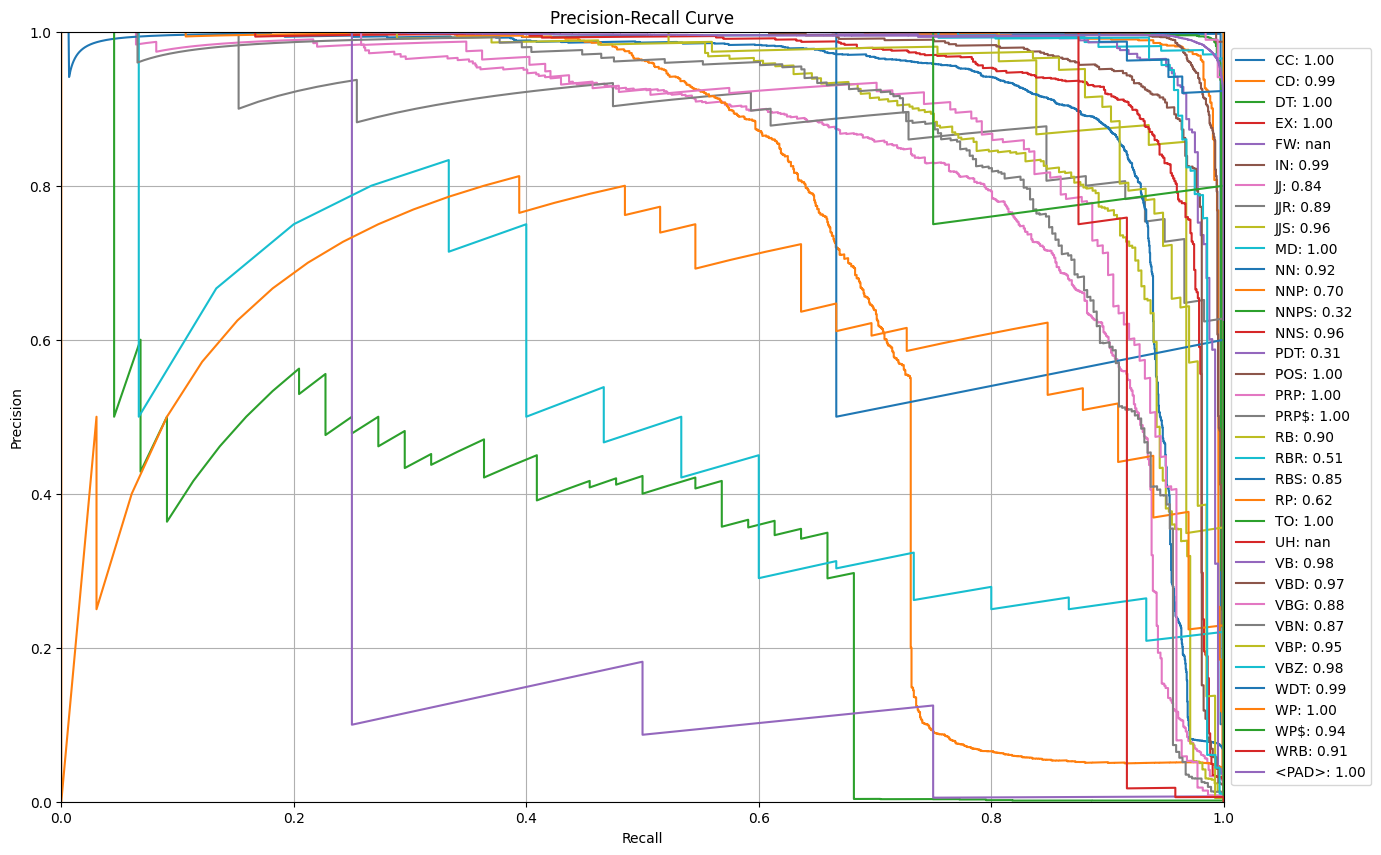

In [25]:
import matplotlib.pyplot as plt
from torchmetrics import PrecisionRecallCurve

precision_curve = PrecisionRecallCurve(task="multiclass", num_classes=best_model.output_dim)


def model_predict(loader, model):
    y_pred = torch.Tensor([])
    y_true = torch.empty(0, dtype=torch.long)

    for batch in loader:
        x_batch, y_true_batch = batch
        y_pred_batch = model(x_batch)
        y_pred_batch = y_pred_batch.reshape(-1, model.output_dim)
        y_true_batch = y_true_batch.reshape(-1)
        y_pred = torch.cat((y_pred, y_pred_batch), dim=0)
        y_true = torch.cat((y_true, y_true_batch), dim=0)

    return y_pred, y_true

y_pred, y_true = model_predict(test_loader, best_model)
    

curve = precision_curve(y_pred, y_true)
precision, recall, _ = curve

plt.figure(figsize=(15, 10))
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()


pos_to_auc = {}
for i in range(best_model.output_dim):
    pos_name = pos_vocab.lookup_token(i)
    
    if pos_name in punctuation_and_symbol_pos:
        continue
                
    auc = -1 * torch.trapz(precision[i], recall[i])
    
    pos_to_auc[pos_name] = auc.item()
    
    plt.plot(recall[i], precision[i], label=f"{pos_name}: {auc:.2f}")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


In [26]:
top_k_hardest = 3
hardest = sorted(pos_to_auc.items(), key=lambda x: x[1])[:top_k_hardest]
print(f"Top 3 hardest pos {hardest}")

Top 3 hardest pos [('PDT', 0.3132553696632385), ('NNPS', 0.3231227993965149), ('RBR', 0.511216402053833)]


### Confusion matrix
The overall confusion matrix is plotted, it is useful to understand which are the most confusing tags.

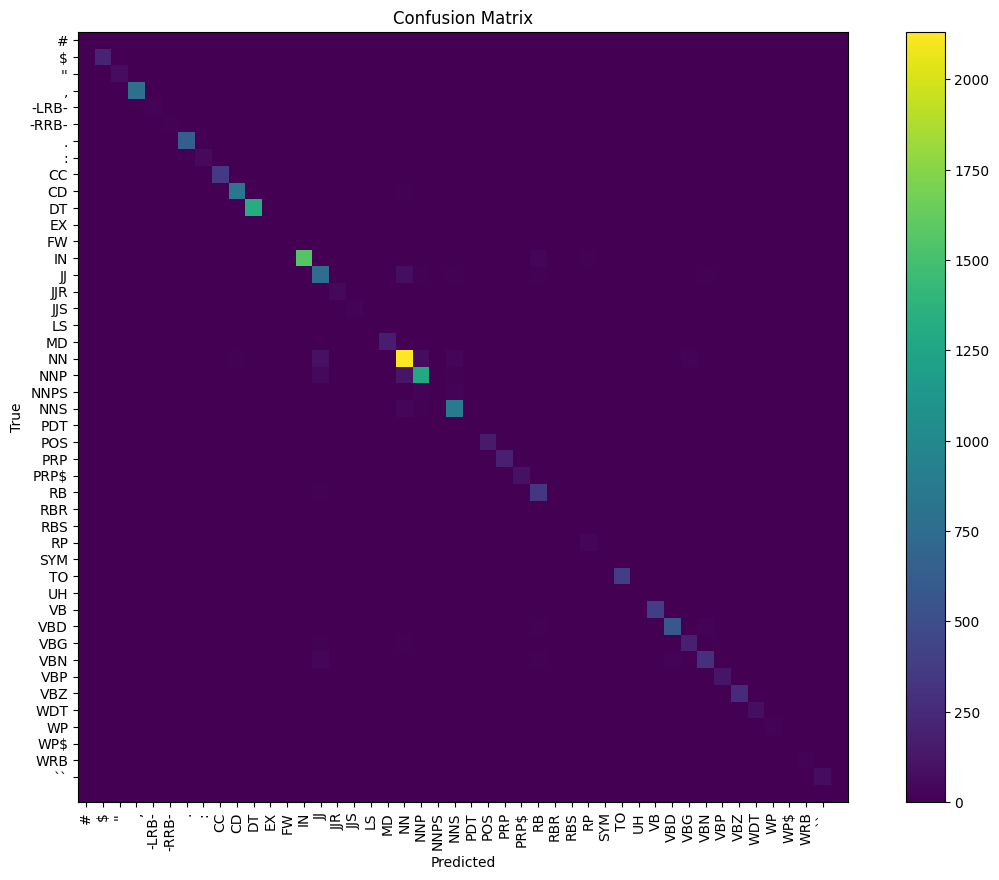

In [27]:
from torchmetrics.classification import MulticlassConfusionMatrix

confusion_matrix_metric = MulticlassConfusionMatrix(num_classes=best_model.output_dim)

y_pred_class = torch.argmax(y_pred, dim=1)
pred_to_plot = y_pred_class[y_true != pos_padding_value]
true_to_plot = y_true[y_true != pos_padding_value]

confusion_matrix = confusion_matrix_metric(pred_to_plot, true_to_plot)

# plot confusion matrix
plt.figure(figsize=(15, 10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.imshow(confusion_matrix)
plt.colorbar()
plt.xticks(range(best_model.output_dim - 1), pos_vocab.get_itos()[:-1])
plt.yticks(range(best_model.output_dim - 1), pos_vocab.get_itos()[:-1])
# x ticks labels vertical
plt.xticks(rotation=90)

plt.show()

### Difficult pairs
From the confusion matrix, it is possible to find the most confused pairs. It is possible to expect that common and proper nouns can be easily confused instead of nouns and proposition or conjuction.   

In [28]:
# Find the maximum value outside the diagonal
confused_pos = {}
    
for i in range(best_model.output_dim):
    if i in punctuation_and_symbol_pos or i == pos_padding_value:
        continue
        
    temp_row = confusion_matrix[i]
    temp_row[i] = -1
    
    # find the pos that is most confused with the current pos
    max_pos = torch.argmax(temp_row)
    
    confused_pos[pos_vocab.lookup_token(i)] = {
        "confused_with": pos_vocab.lookup_token(max_pos),
        "n_errors": temp_row[max_pos].item()
    }
    

top_k_most_confused = 6
most_confused = sorted(confused_pos.items(), key=lambda x: x[1]["n_errors"], reverse=True)[:top_k_most_confused]

for i, (pos, info) in enumerate(most_confused):
    print(f"Top {i + 1} most confused pos: {pos}, confused with {info['confused_with']} with {info['n_errors']} errors")

Top 1 most confused pos: NNP, confused with NN with 122 errors
Top 2 most confused pos: NN, confused with JJ with 96 errors
Top 3 most confused pos: JJ, confused with NN with 78 errors
Top 4 most confused pos: IN, confused with RB with 36 errors
Top 5 most confused pos: NNS, confused with NN with 35 errors
Top 6 most confused pos: VBN, confused with JJ with 33 errors


### Analysis of some misclassified samples
The most difficult sentences are shown here. 

In [31]:
from sklearn.metrics import f1_score 

def model_predict_sentence(sentence: list[str]):
    sentence = [token.lower() for token in sentence]
    embedded_text = embedder.get_vecs_by_tokens(sentence)
    pred = best_model(embedded_text)
    pred_class = torch.argmax(pred, dim=1)
    pred_token = [pos_vocab.lookup_token(i) for i in pred_class]
    return pred_token    


result = []
id_max = df_test["id"].max()
tot_errors = 0
cap_errors = 0
for id in range(id_max):
    group = df_test.groupby("id").get_group(id)
    
    text = group["text"].to_list()
    ground_truth = group["POS"].to_list()
    prediction = model_predict_sentence(text)
    
    # insert into a dataframe
    df = pd.DataFrame({"text": text, "ground_truth": ground_truth, "prediction": prediction})
    
    # compute f1 score
    f1 = f1_score(ground_truth, prediction, average="macro")
    
    # compute number of errors
    n_errors = len(df[df["ground_truth"] != df["prediction"]])

    # update total errors and capitalization errors
    tot_errors += n_errors

    token_errors = df[df["ground_truth"] != df["prediction"]]["text"].to_list()
    cap_errors += sum(s[0].isupper() for s in token_errors)

    result.append({
        "df": df,
        "n_errors": n_errors,
        "f1_score": f1,
        "id": id
    })


top_k_hardest = 3

for i, res in enumerate(sorted(result, key=lambda x: x["f1_score"], reverse=False)[:top_k_hardest]):
    print(f"Top {i + 1} hardest sentence: {res['id']}, with {res['n_errors']} errors and f1 score {res['f1_score']}")
    display(res["df"])

Top 1 hardest sentence: 74, with 3 errors and f1 score 0.2


,text,ground_truth,prediction
0,GRAINS,NNPS,NNS
1,AND,NNP,CC
2,SOYBEANS,NNPS,NNS
3,:,:,:


Top 2 hardest sentence: 82, with 1 errors and f1 score 0.3333333333333333


,text,ground_truth,prediction
0,COPPER,NNP,NN
1,:,:,:


Top 3 hardest sentence: 329, with 2 errors and f1 score 0.5


,text,ground_truth,prediction
0,Stocks,NNS,NNS
1,:,:,:
2,Volume,NN,JJ
3,"154,240,000",CD,NN
4,shares,NNS,NNS
5,.,.,.


Sentence one is a clear example of misslabeled data: even though it is a title of an article, it's not justified to label "GRAINS" and "SOYBEANS" as **proper** nouns. Even worse, "AND" cannot be a proper noun but is here a conjunction, as correctly predicted by the model.

For a better understanding of the errors portrayed above, here is the translation of the POS codes to their meaning, from the Penn Treebank dataset page:

1. **CC**  Coordinating conjunction  
2. **CD**  Cardinal number           
3. **DT**  Determiner                
4. **EX**  Existential there  	 
5. **FW**  Foreign word              
6. **IN**  Preposition/subord. conjunction  	
7. **JJ**  Adjective                 
8. **JJR** Adjective, comparative    
9. **JJS** Adjective, superlative    
10. **LS**  List item marker          
11. **MD**  Modal                     
12. **NN**  Noun, singular or mass    
13. **NNS** Noun, plural             
14. **NNP** Proper noun, singular     
15. **NNPS** Proper noun, plural      
16. **PDT** Predeterminer             
17. **POS** Possessive ending          
18. **PRP** Personal pronoun           
19. **PP**  Possessive pronoun         
20. **RB**  Adverb                    
21. **RBR** Adverb, comparative        
22. **RBS** Adverb, superlative       
23. **RP**  Particle                  
24. **SYM** Symbol
25. **TO**  to 
26. **UH**  Interjection 
27. **VB**  Verb, base form 
28. **VBD** Verb, past tense 
29. **VBG** Verb, gerund/present participle 
30. **VBN** Verb, past participle 
31. **VBP** Verb, non-3rd ps. sing. present 
32. **VBZ** Verb, 3rd ps. sing. present 
33. **WDT** wh-determiner 
34. **WP**  wh-pronoun 
35. **WP**  Possessive wh-pronoun 
36. **WRB** wh-adverb 

In [ ]:
print(f"The number of capitalization errors is {cap_errors} out of {tot_errors} total errors")
print(f"The percentage of capitalization errors is {round(cap_errors / tot_errors * 100, 2)}%")

The number of capitalization errors is 310 out of 1212 total errors
The percentage of capitalization errors is 25.58%


Notably, a big percentage of errors are on capitalized (in the original dataset, before preprocessing) work tokens. This could be explained by the fact that we make all tokens lowercase as a preprocessing step, and hence lose information.

## Task 7: Report

The report can be found in this folder, with the name *report.pdf*

We included here a plot of the training and validation loss and macro F1 score during training (obtained using TensorBoard)

<center>
    <img src="images/learning_curves.png" alt="Learning curves plots" />
</center>